In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
seed = 42
np.random.seed(seed)

In [3]:
df = pd.read_csv('poster_presentation.csv', index_col=0)
print(df.shape)
print(df['Label'].value_counts())
print(df['Label_numeric'].value_counts())
X = df.iloc[:, :200].to_numpy()
y = df.iloc[:, -1].to_numpy()

(107400, 202)
Label
N    89429
Q     7999
V     6392
S     2805
F      775
Name: count, dtype: int64
Label_numeric
1    89429
2     7999
4     6392
3     2805
0      775
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, stratify=y_test, shuffle=True)
print(X_train.shape, X_test.shape, X_val.shape)

(75180, 200) (21587, 200) (10633, 200)


In [5]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
import random

# please do not modify this!
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device
print(f"Device: {device}")

/home/csci5980/tirup007/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchsummary import summary

In [7]:
NUM_EPOCHS=100
BATCH_SIZE=100
lr = 1e-3

In [8]:
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [16]:
train_dataset = ECGDataset(torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 200), torch.tensor(y_train, dtype=torch.long))
test_dataset = ECGDataset(torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 200), torch.tensor(y_test, dtype=torch.long))
valid_dataset = ECGDataset(torch.tensor(X_val, dtype=torch.float32).reshape(-1, 1, 200), torch.tensor(y_val, dtype=torch.long))
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

75180
21587
10633


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
class ECG_CNN(nn.Module):
    def __init__(self) -> None:
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2, 1),
            nn.BatchNorm1d(32)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, 3),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool1d(2, 1),
            nn.BatchNorm1d(128)
        )
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*190, 100),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.final = nn.Linear(50, 5)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        X = self.fc1(X)
        X = self.fc2(X)
        return self.final(X)

In [19]:
model = ECG_CNN()
print(model)

ECG_CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=24320, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features

In [35]:
summary(model, (1, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 198]              64
              ReLU-2              [-1, 16, 198]               0
            Conv1d-3              [-1, 32, 196]           1,568
              ReLU-4              [-1, 32, 196]               0
         MaxPool1d-5              [-1, 32, 195]               0
       BatchNorm1d-6              [-1, 32, 195]              64
            Conv1d-7              [-1, 64, 193]           6,208
              ReLU-8              [-1, 64, 193]               0
            Conv1d-9             [-1, 128, 191]          24,704
             ReLU-10             [-1, 128, 191]               0
        MaxPool1d-11             [-1, 128, 190]               0
      BatchNorm1d-12             [-1, 128, 190]             256
          Flatten-13                [-1, 24320]               0
           Linear-14                  [

In [20]:
def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='models/model', epochs=30):

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):

        # Set model to train mode
        model.train()

        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='mini-batch')

        # Batch loop
        for inputs, labels in progress_bar:

            # Move input data to device (only strictly necessary if we use GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.

            optimizer.zero_grad()

            # Run the model on the input data and compute the outputs
            outputs = model(inputs)
            # outputs = outputs.squeeze(dim=1)

            # Calculate the loss
            loss = loss_module(outputs, labels)

            # Perform backpropagation
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Calculate the loss for current iteration
            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)


        # Set model to eval mode for validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():

            for inputs, labels in valid_loader:

                # For validation batches, calculate the output, and loss in a similar way
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # outputs = outputs.squeeze(dim=1)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Valid Loss: {valid_loss:.4f}')

        # Save the model's state_dict at end of each epoch
        torch.save(model.state_dict(), f'{path}-{epoch+1}.pth')

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    return training_losses, validation_losses

In [21]:
def plot_learning_curves(training_losses, validation_losses):

    # Plot epoch wise training and validation losses (both in the same plot)

    assert len(training_losses) == len(validation_losses)

    # YOUR CODE HERE
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend(loc="best")
    plt.show()

Epoch 1/100, Train Loss: 0.2303,  Valid Loss: 0.1183


Epoch 2/100, Train Loss: 0.1288,  Valid Loss: 0.0843


Epoch 3/100, Train Loss: 0.1029,  Valid Loss: 0.0687


Epoch 4/100, Train Loss: 0.0894,  Valid Loss: 0.0624


Epoch 5/100, Train Loss: 0.0804,  Valid Loss: 0.0569


Epoch 6/100, Train Loss: 0.0713,  Valid Loss: 0.0569


Epoch 7/100, Train Loss: 0.0682,  Valid Loss: 0.0605


Epoch 8/100, Train Loss: 0.0620,  Valid Loss: 0.0629


Epoch 9/100, Train Loss: 0.0613,  Valid Loss: 0.0610


Epoch 10/100, Train Loss: 0.0550,  Valid Loss: 0.0525


Epoch 11/100, Train Loss: 0.0517,  Valid Loss: 0.0691


Epoch 12/100, Train Loss: 0.0488,  Valid Loss: 0.0557


Epoch 13/100, Train Loss: 0.0484,  Valid Loss: 0.0553


Epoch 14/100, Train Loss: 0.0437,  Valid Loss: 0.0659


Epoch 15/100, Train Loss: 0.0426,  Valid Loss: 0.0771


Epoch 16/100, Train Loss: 0.0419,  Valid Loss: 0.0673


Epoch 17/100, Train Loss: 0.0367,  Valid Loss: 0.0684


Epoch 18/100, Train Loss: 0.0388,  Valid Loss: 0.0707


Epoch 19/100, Train Loss: 0.0351,  Valid Loss: 0.0679


Epoch 20/100, Train Loss: 0.0352,  Valid Loss: 0.0791


Epoch 21/100, Train Loss: 0.0347,  Valid Loss: 0.0680


Epoch 22/100, Train Loss: 0.0325,  Valid Loss: 0.0734


Epoch 23/100, Train Loss: 0.0306,  Valid Loss: 0.0889


Epoch 24/100, Train Loss: 0.0317,  Valid Loss: 0.0696


Epoch 25/100, Train Loss: 0.0301,  Valid Loss: 0.0803


Epoch 26/100, Train Loss: 0.0313,  Valid Loss: 0.0789


Epoch 27/100, Train Loss: 0.0262,  Valid Loss: 0.0830


Epoch 28/100, Train Loss: 0.0284,  Valid Loss: 0.0777


Epoch 29/100, Train Loss: 0.0286,  Valid Loss: 0.1039


Epoch 30/100, Train Loss: 0.0273,  Valid Loss: 0.0864


Epoch 31/100, Train Loss: 0.0264,  Valid Loss: 0.0889


Epoch 32/100, Train Loss: 0.0289,  Valid Loss: 0.0778


Epoch 33/100, Train Loss: 0.0284,  Valid Loss: 0.0954


Epoch 34/100, Train Loss: 0.0240,  Valid Loss: 0.1023


Epoch 35/100, Train Loss: 0.0231,  Valid Loss: 0.1154


Epoch 36/100, Train Loss: 0.0244,  Valid Loss: 0.0842


Epoch 37/100, Train Loss: 0.0220,  Valid Loss: 0.1112


Epoch 38/100, Train Loss: 0.0225,  Valid Loss: 0.0826


Epoch 39/100, Train Loss: 0.0281,  Valid Loss: 0.0884


Epoch 40/100, Train Loss: 0.0226,  Valid Loss: 0.1003


Epoch 41/100, Train Loss: 0.0212,  Valid Loss: 0.1010


Epoch 42/100, Train Loss: 0.0227,  Valid Loss: 0.0989


Epoch 43/100, Train Loss: 0.0226,  Valid Loss: 0.1167


Epoch 44/100, Train Loss: 0.0207,  Valid Loss: 0.1113


Epoch 45/100, Train Loss: 0.0202,  Valid Loss: 0.1046


Epoch 46/100, Train Loss: 0.0222,  Valid Loss: 0.1035


Epoch 47/100, Train Loss: 0.0211,  Valid Loss: 0.1283


Epoch 48/100, Train Loss: 0.0221,  Valid Loss: 0.1056


Epoch 49/100, Train Loss: 0.0206,  Valid Loss: 0.1026


Epoch 50/100, Train Loss: 0.0206,  Valid Loss: 0.1226


Epoch 51/100, Train Loss: 0.0206,  Valid Loss: 0.1465


Epoch 52/100, Train Loss: 0.0188,  Valid Loss: 0.1201


Epoch 53/100, Train Loss: 0.0229,  Valid Loss: 0.1465


Epoch 54/100, Train Loss: 0.0201,  Valid Loss: 0.1672


Epoch 55/100, Train Loss: 0.0206,  Valid Loss: 0.1221


Epoch 56/100, Train Loss: 0.0205,  Valid Loss: 0.0909


Epoch 57/100, Train Loss: 0.0167,  Valid Loss: 0.1398


Epoch 58/100, Train Loss: 0.0212,  Valid Loss: 0.1234


Epoch 59/100, Train Loss: 0.0196,  Valid Loss: 0.0918


Epoch 60/100, Train Loss: 0.0180,  Valid Loss: 0.1201


Epoch 61/100, Train Loss: 0.0195,  Valid Loss: 0.1065


Epoch 62/100, Train Loss: 0.0200,  Valid Loss: 0.1114


Epoch 63/100, Train Loss: 0.0191,  Valid Loss: 0.1417


Epoch 64/100, Train Loss: 0.0217,  Valid Loss: 0.1112


Epoch 65/100, Train Loss: 0.0187,  Valid Loss: 0.1010


Epoch 66/100, Train Loss: 0.0189,  Valid Loss: 0.1171


Epoch 67/100, Train Loss: 0.0182,  Valid Loss: 0.1092


Epoch 68/100, Train Loss: 0.0177,  Valid Loss: 0.1480


Epoch 69/100, Train Loss: 0.0177,  Valid Loss: 0.1114


Epoch 70/100, Train Loss: 0.0154,  Valid Loss: 0.1504


Epoch 71/100, Train Loss: 0.0151,  Valid Loss: 0.1295


Epoch 72/100, Train Loss: 0.0186,  Valid Loss: 0.1497


Epoch 73/100, Train Loss: 0.0213,  Valid Loss: 0.1126


Epoch 74/100, Train Loss: 0.0196,  Valid Loss: 0.1247


Epoch 75/100, Train Loss: 0.0183,  Valid Loss: 0.1846


Epoch 76/100, Train Loss: 0.0173,  Valid Loss: 0.1347


Epoch 77/100, Train Loss: 0.0174,  Valid Loss: 0.1621


Epoch 78/100, Train Loss: 0.0205,  Valid Loss: 0.1474


Epoch 79/100, Train Loss: 0.0180,  Valid Loss: 0.1479


Epoch 80/100, Train Loss: 0.0192,  Valid Loss: 0.1668


Epoch 81/100, Train Loss: 0.0167,  Valid Loss: 0.1794


Epoch 82/100, Train Loss: 0.0170,  Valid Loss: 0.2027


Epoch 83/100, Train Loss: 0.0187,  Valid Loss: 0.1318


Epoch 84/100, Train Loss: 0.0170,  Valid Loss: 0.1327


Epoch 85/100, Train Loss: 0.0188,  Valid Loss: 0.1642


Epoch 86/100, Train Loss: 0.0167,  Valid Loss: 0.1564


Epoch 87/100, Train Loss: 0.0152,  Valid Loss: 0.1248


Epoch 88/100, Train Loss: 0.0140,  Valid Loss: 0.1578


Epoch 89/100, Train Loss: 0.0176,  Valid Loss: 0.1085


Epoch 90/100, Train Loss: 0.0158,  Valid Loss: 0.1513


Epoch 91/100, Train Loss: 0.0152,  Valid Loss: 0.1352


Epoch 92/100, Train Loss: 0.0188,  Valid Loss: 0.1448


Epoch 93/100, Train Loss: 0.0190,  Valid Loss: 0.1896


Epoch 94/100, Train Loss: 0.0143,  Valid Loss: 0.1207


Epoch 95/100, Train Loss: 0.0172,  Valid Loss: 0.1609


Epoch 96/100, Train Loss: 0.0153,  Valid Loss: 0.1763


Epoch 97/100, Train Loss: 0.0154,  Valid Loss: 0.1646


Epoch 98/100, Train Loss: 0.0177,  Valid Loss: 0.1596


Epoch 99/100, Train Loss: 0.0180,  Valid Loss: 0.1703


Epoch 100/100, Train Loss: 0.0135,  Valid Loss: 0.1808


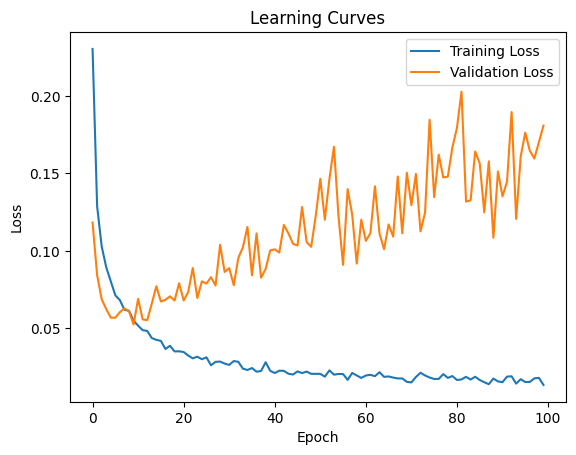

In [22]:
model.to(device)

loss_module = nn.CrossEntropyLoss()

# You can use '0.0001' as learning rate for the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


training_losses, validation_losses = train_model(model, loss_module, optimizer, train_dataloader, valid_dataloader, device, "models/cnn", NUM_EPOCHS)
plot_learning_curves(training_losses, validation_losses)

In [24]:
def test_model(model, test_loader, loss_module):

    true_labels = []
    predicted_labels = []

    running_correct = 0
    running_loss=0.0
    # Set model to eval mode
    model.eval()

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_module(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted==labels).sum().item()

            true_labels.extend(labels.cpu().numpy().astype(int))
            predicted_labels.extend(predicted.cpu().numpy())
        
        accuracy = (running_correct/len(true_labels)) * 100
        loss = (running_loss/len(true_labels))
    return true_labels, predicted_labels, accuracy, loss


In [28]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap=plt.cm.Blues)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

In [29]:
model_opt = ECG_CNN()
model_opt.load_state_dict(torch.load('models/cnn-10.pth'))
model_opt.to(device)
true_labels, predicted_labels, test_acc, test_loss = test_model(model_opt, test_dataloader, loss_module)

assert(len(true_labels) == len(predicted_labels))

Test Accuracy: 98.69365822022513
 Test Loss: 0.0005434688456626082
              precision    recall  f1-score   support

           0     0.9600    0.7742    0.8571       155
           1     0.9876    0.9977    0.9926     17975
           2     0.9969    0.9963    0.9966      1608
           3     0.9312    0.7199    0.8120       564
           4     0.9865    0.9681    0.9772      1285

    accuracy                         0.9869     21587
   macro avg     0.9724    0.8912    0.9271     21587
weighted avg     0.9866    0.9869    0.9863     21587



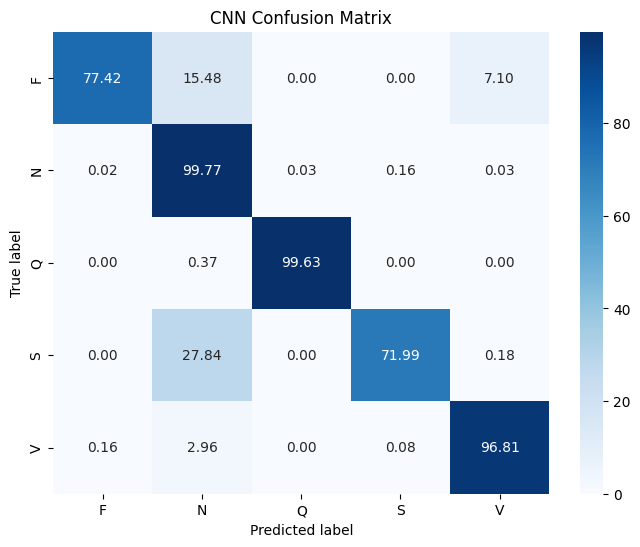

In [36]:
print(f"Test Accuracy: {test_acc}\n Test Loss: {test_loss}")
print(classification_report(true_labels, predicted_labels, digits=4))
plot_confusion_matrix(confusion_matrix(true_labels, predicted_labels), np.array(['F','N','Q','S','V']), "CNN Confusion Matrix")